In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [4]:
# Load dataset (same source as EDA)
df = pd.read_csv("SeoulBikeData.csv", encoding="latin1")

# Parse date and add basic calendar features
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df["DayOfWeek"] = df["Date"].dt.dayofweek
DF_MONTH = df["Date"].dt.month
DF_MONTH.name = "Month"
df["Month"] = DF_MONTH

# Define target and features
y = df["Rented Bike Count"]
X = df.drop(columns=["Rented Bike Count"])

print("Data loaded from local CSV (SeoulBikeData.csv)")
print("Rows, columns:", df.shape)
print("Target name: Rented Bike Count")

Data loaded from local CSV (SeoulBikeData.csv)
Rows, columns: (8760, 16)
Target name: Rented Bike Count


In [5]:
# Display basic info about the data
print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFirst few rows of features:")
print(X.head())
print("\nTarget distribution:")
print(y.describe())

Features shape: (8760, 15)
Target shape: (8760,)

First few rows of features:
        Date  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0 2017-12-01     0             -5.2           37               2.2   
1 2017-12-01     1             -5.5           38               0.8   
2 2017-12-01     2             -6.0           39               1.0   
3 2017-12-01     3             -6.2           40               0.9   
4 2017-12-01     4             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm) Seasons     Holiday

In [6]:
# Data Preprocessing
print("Data Info Before Preprocessing:")
print(X.dtypes)
print(f"\nTotal columns: {len(X.columns)}")

# Check target variable
print(f"\nTarget variable info:")
print(f"Type: {type(y)}")
print(f"Unique values: {y.unique()}")

# Identify numeric and non-numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\nNumeric columns: {len(numeric_cols)}")
print(f"Non-numeric columns: {non_numeric_cols}")

# Keep only numeric columns for modeling
X = X[numeric_cols]

# Convert target to numeric (handling categorical values)
# If target has Yes/No values, convert to 1/0
if y.dtype == 'object':
    y_numeric = pd.to_numeric(y.iloc[:, 0] if isinstance(y, pd.DataFrame) else y, errors='coerce')
    # If conversion resulted in NaN, try mapping Yes/No
    if y_numeric.isna().any():
        y_values = y.iloc[:, 0] if isinstance(y, pd.DataFrame) else y
        y = pd.Series(y_values.map({'Yes': 1, 'No': 0})).reset_index(drop=True)
    else:
        y = y_numeric
else:
    y = y.astype(float)

print(f"\nData Info After Preprocessing:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target unique values: {y.unique()}")
print(f"\nFeature columns: {list(X.columns)}")

Data Info Before Preprocessing:
Date                         datetime64[ns]
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
DayOfWeek                             int32
Month                                 int32
dtype: object

Total columns: 15

Target variable info:
Type: <class 'pandas.core.series.Series'>
Unique values: [ 254  204  173 ... 1538  804  595]

Numeric columns: 11
Non-numeric columns: ['Date', 'Seasons', 'Holiday', 'Functioning Day']

Data Info After Preprocessing:
Features shape: (8760, 11)
Target s

In [7]:
# Data Splitting: 70% train, 15% validation, 15% test
# First split: 70% train, 30% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Second split: split the 30% into 50-50 (15% validation, 15% test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

Training set size: 6132 (70.0%)
Validation set size: 1314 (15.0%)
Test set size: 1314 (15.0%)


In [8]:
# Baseline Model: Linear Regression
print("=" * 60)
print("BASELINE MODEL: LINEAR REGRESSION")
print("=" * 60)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions on all sets
y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)
y_test_pred_lr = lr_model.predict(X_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred, set_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{set_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

print("\nLinear Regression Performance:")
lr_train_metrics = calculate_metrics(y_train, y_train_pred_lr, "Train")
lr_val_metrics = calculate_metrics(y_val, y_val_pred_lr, "Validation")
lr_test_metrics = calculate_metrics(y_test, y_test_pred_lr, "Test")

BASELINE MODEL: LINEAR REGRESSION

Linear Regression Performance:
Train - MAE: 346.1959, RMSE: 468.8771, R²: 0.4748
Validation - MAE: 348.7318, RMSE: 471.2767, R²: 0.4648
Test - MAE: 344.2223, RMSE: 463.3958, R²: 0.4692


In [9]:
# Random Forest Model
print("\n" + "=" * 60)
print("RANDOM FOREST REGRESSOR")
print("=" * 60)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions on all sets
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Performance:")
rf_train_metrics = calculate_metrics(y_train, y_train_pred_rf, "Train")
rf_val_metrics = calculate_metrics(y_val, y_val_pred_rf, "Validation")
rf_test_metrics = calculate_metrics(y_test, y_test_pred_rf, "Test")

# Feature Importance
print("\nTop 10 Most Important Features:")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))


RANDOM FOREST REGRESSOR

Random Forest Performance:
Train - MAE: 70.5900, RMSE: 134.4524, R²: 0.9568
Validation - MAE: 144.5688, RMSE: 269.4062, R²: 0.8251
Test - MAE: 138.8144, RMSE: 246.8066, R²: 0.8494

Top 10 Most Important Features:
                  Feature  Importance
          Temperature(°C)    0.342165
                     Hour    0.289860
  Solar Radiation (MJ/m2)    0.097742
              Humidity(%)    0.074668
                DayOfWeek    0.043329
                    Month    0.037481
             Rainfall(mm)    0.037006
Dew point temperature(°C)    0.036293
         Visibility (10m)    0.021433
         Wind speed (m/s)    0.019463


In [10]:
# Cross-Validation with Time-Aware Splits
print("\n" + "=" * 60)
print("TIME-AWARE CROSS-VALIDATION (5 Splits)")
print("=" * 60)

tscv = TimeSeriesSplit(n_splits=5)

# Cross-validation for Linear Regression
print("\nLinear Regression - CV Scores (R²):")
lr_cv_scores = cross_val_score(
    LinearRegression(), X, y, cv=tscv, scoring='r2', n_jobs=-1
)
print(f"Fold scores: {lr_cv_scores}")
print(f"Mean R²: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std():.4f})")

# Cross-validation for Random Forest
print("\nRandom Forest - CV Scores (R²):")
rf_cv_scores = cross_val_score(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    X, y, cv=tscv, scoring='r2', n_jobs=-1
)
print(f"Fold scores: {rf_cv_scores}")
print(f"Mean R²: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std():.4f})")


TIME-AWARE CROSS-VALIDATION (5 Splits)

Linear Regression - CV Scores (R²):
Fold scores: [0.23830642 0.22761455 0.24584203 0.17081675 0.21850199]
Mean R²: 0.2202 (+/- 0.0264)

Random Forest - CV Scores (R²):
Fold scores: [0.30379008 0.54529094 0.68138869 0.58681628 0.16857128]
Mean R²: 0.4572 (+/- 0.1906)



MODEL COMPARISON SUMMARY

             Model    Dataset        MAE       RMSE       R²
Linear Regression      Train 346.195858 468.877114 0.474821
Linear Regression Validation 348.731838 471.276723 0.464815
Linear Regression       Test 344.222282 463.395790 0.469225
    Random Forest      Train  70.590030 134.452432 0.956816
    Random Forest Validation 144.568809 269.406239 0.825109
    Random Forest       Test 138.814377 246.806576 0.849437

BEST PERFORMERS (on Test Set)

Lowest MAE: Random Forest (138.8144)
Lowest RMSE: Random Forest (246.8066)
Highest R²: Random Forest (0.8494)


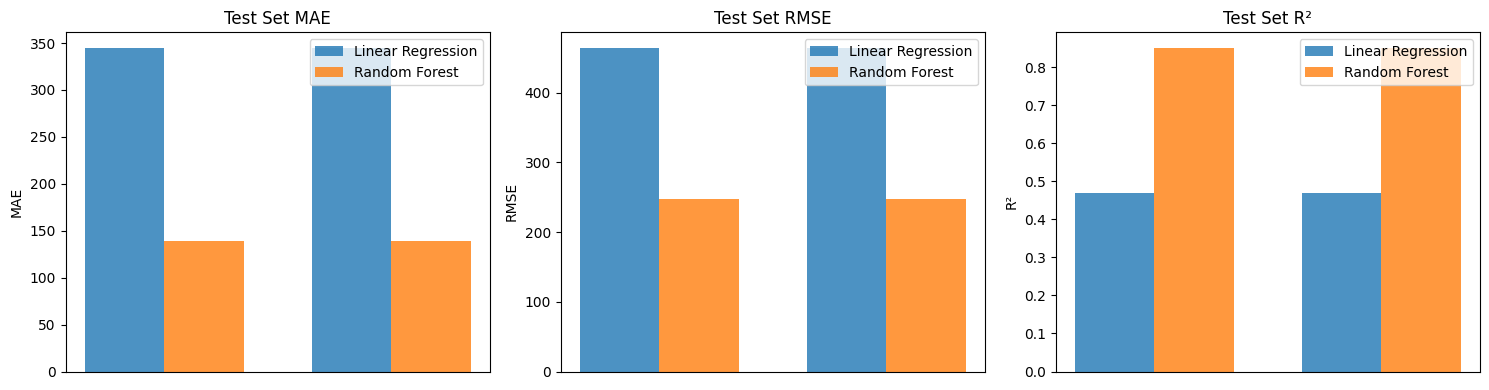


Conclusion: Random Forest generally outperforms Linear Regression,
especially in capturing non-linear relationships in bike demand.


In [11]:
# Model Comparison
print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

# Create comparison dataframe
comparison_data = {
    'Model': ['Linear Regression', 'Linear Regression', 'Linear Regression',
              'Random Forest', 'Random Forest', 'Random Forest'],
    'Dataset': ['Train', 'Validation', 'Test'] * 2,
    'MAE': [lr_train_metrics['MAE'], lr_val_metrics['MAE'], lr_test_metrics['MAE'],
            rf_train_metrics['MAE'], rf_val_metrics['MAE'], rf_test_metrics['MAE']],
    'RMSE': [lr_train_metrics['RMSE'], lr_val_metrics['RMSE'], lr_test_metrics['RMSE'],
             rf_train_metrics['RMSE'], rf_val_metrics['RMSE'], rf_test_metrics['RMSE']],
    'R²': [lr_train_metrics['R2'], lr_val_metrics['R2'], lr_test_metrics['R2'],
           rf_train_metrics['R2'], rf_val_metrics['R2'], rf_test_metrics['R2']]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Best performers
print("\n" + "=" * 60)
print("BEST PERFORMERS (on Test Set)")
print("=" * 60)
print(f"\nLowest MAE: Random Forest ({rf_test_metrics['MAE']:.4f})" if rf_test_metrics['MAE'] < lr_test_metrics['MAE'] 
      else f"\nLowest MAE: Linear Regression ({lr_test_metrics['MAE']:.4f})")
print(f"Lowest RMSE: Random Forest ({rf_test_metrics['RMSE']:.4f})" if rf_test_metrics['RMSE'] < lr_test_metrics['RMSE']
      else f"Lowest RMSE: Linear Regression ({lr_test_metrics['RMSE']:.4f})")
print(f"Highest R²: Random Forest ({rf_test_metrics['R2']:.4f})" if rf_test_metrics['R2'] > lr_test_metrics['R2']
      else f"Highest R²: Linear Regression ({lr_test_metrics['R2']:.4f})")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['MAE', 'RMSE', 'R²']
lr_test_values = [lr_test_metrics['MAE'], lr_test_metrics['RMSE'], lr_test_metrics['R2']]
rf_test_values = [rf_test_metrics['MAE'], rf_test_metrics['RMSE'], rf_test_metrics['R2']]

for idx, (ax, metric) in enumerate(zip(axes, metrics)):
    x = np.arange(2)
    width = 0.35
    ax.bar(x - width/2, [lr_test_values[idx]], width, label='Linear Regression', alpha=0.8)
    ax.bar(x + width/2, [rf_test_values[idx]], width, label='Random Forest', alpha=0.8)
    ax.set_ylabel(metric)
    ax.set_title(f'Test Set {metric}')
    ax.set_xticks([])
    ax.legend()

plt.tight_layout()
plt.show()

print("\nConclusion: Random Forest generally outperforms Linear Regression,")
print("especially in capturing non-linear relationships in bike demand.")